In [1]:
import sys 
from sklearn.metrics import confusion_matrix
import load_data
import my_metrics
import numpy as np
import plot_learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
#from xgboost import XGBClassifier
import pandas as pd
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score,precision_score,recall_score
import seaborn as sns
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import shap
import xgboost as xgb 
from xgboost import XGBClassifier
%matplotlib inline

(22800, 92)
(22800, 86)
(1991, 92)
(20809, 92)
lhflx       float64
shflx       float64
Tsair       float64
RHair       float64
ddcape      float64
lcl         float64
T_117       float64
T_138       float64
T_162       float64
T_191       float64
T_226       float64
T_268       float64
T_316       float64
T_374       float64
T_441       float64
T_521       float64
T_607       float64
T_689       float64
T_761       float64
T_819       float64
T_858       float64
T_886       float64
T_912       float64
T_936       float64
T_957       float64
T_976       float64
Q_117       float64
Q_138       float64
Q_162       float64
Q_191       float64
             ...   
divs_912    float64
divs_936    float64
divs_957    float64
divs_976    float64
divq_117    float64
divq_138    float64
divq_162    float64
divq_191    float64
divq_226    float64
divq_268    float64
divq_316    float64
divq_374    float64
divq_441    float64
divq_521    float64
divq_607    float64
divq_689    float64
divq_761    f

<Figure size 1152x648 with 0 Axes>

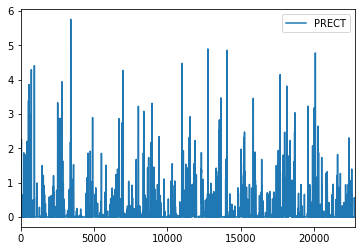

In [2]:
dilute_cape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/dilute_cape")
dilute_dcape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/dilute_dcape")
undilute_dcape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/undilute_dcape")
undilute_cape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/undilute_cape")
lcl = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/dilute_lcl")

dataset = load_data.load_sgp_data("../../data/sgp/arm_continuous_at_sgp/Arm_CF_1999_2009_hy.nc")
dataset['cape'] = dilute_dcape
dataset['lcl'] = lcl
dataset.rename(columns={'cape': 'ddcape'}, inplace=True)
print(dataset.shape)

trig_x = dataset.iloc[:,0:86]
trig_y = dataset.iloc[:,86]

pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]

print(trig_x.shape)
print(pos.shape)
print(neg.shape)

plt.figure(figsize=(16,9))
dataset.plot(y='PRECT')

print(dataset.dtypes)

In [28]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
cape_trigger = np.zeros(trig_y_test.shape)

#print(trig_x_test)
TP = 0
FP = 0
FN = 0
TN = 0

for i in range(len(trig_y_test)):
    if trig_x_test.iloc[i,4] > 149.877 and trig_x_test.iloc[i,3] > 60.086:
        if trig_y_test.iloc[i]== 1:
            TP=TP+1
        else:
            FP = FP+1
    elif trig_x_test.iloc[i,4] <= 56.161 and trig_x_test.iloc[i,3] <= 85.196:
        if trig_y_test.iloc[i] == 0:
            TN = TN+1
        else:
            FN = FN+1

#tn, fp, fn, tp = confusion_matrix(trig_y_test, cape_trigger).ravel()
#f1 = f1_score(trig_y_test, cape_trigger,average='macro')
#p  = precision_score(trig_y_test, cape_trigger,average='macro')
#r  = recall_score(trig_y_test, cape_trigger,average='macro')

Precision_P = TP/(TP+FP)
Precision_N = TN/(TN+FN)
Recall_P = TP/(TP+FN)
Recall_N = TN/(TN+FP)
F1_P = 2 * Precision_P * Recall_P / (Precision_P + Recall_P)
F1_N = 2 * Precision_N * Recall_N / (Precision_N + Recall_N)

P  = (Precision_P + Precision_N) / 2
R  = (Recall_P + Recall_N) / 2
F1 = (F1_P+F1_N)/2
ratio = (TP+FP+TN+FN)/len(trig_y_test)
print(ratio)
print(F1, P, R)

0.7839912280701754
0.8510102132672454 0.9665196628800321 0.7846132333103017


1. thres=65, 0.77 0.82, 0.73
2. thres=56, 0.77 0.81  0.74
3. N: cape <=22.441, RHair <=85.196; Y: cape > 149, RHair > 60.086, 0.87, 0.97, 0.81 75.4%


In [46]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:hinge'  # error evaluation for multiclass training
}  # the number of classes that exist in this datset
num_round = 600  # the number of training iterations
bst = xgb.train(param, xgb.DMatrix(trig_x, label=trig_y), num_round)

In [47]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(trig_x)

In [48]:
print(shap_values)
print(shap_values.shape)

[[ 0.19771247  0.36461437  0.2843864  ... -0.06406161 -0.48940092
   0.02701898]
 [ 0.27551603  0.29944295  0.21346812 ... -0.10194935 -0.45758086
   0.03245402]
 [ 0.29291916  0.3815375   0.22645073 ... -0.02172667 -0.39683795
  -0.2504295 ]
 ...
 [-0.9242188  -0.28270543  0.04775076 ...  0.00664037 -0.04732786
  -0.08474261]
 [ 0.152605   -0.22810467  0.02401507 ...  0.01981128 -0.01050897
  -0.0751268 ]
 [-0.27199548  0.32631317  0.04253825 ...  0.01981128 -0.01050897
  -0.0751268 ]]
(22800, 86)


In [41]:
shap.initjs()
print(explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[5], trig_x.iloc[5],link="logit")

-53.787178


In [11]:
shap.initjs()
print(explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[35], trig_x.iloc[35],link="logit")

-4.544473


In [12]:
shap.initjs()
print(explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[135], trig_x.iloc[135],link="logit")

-4.544473


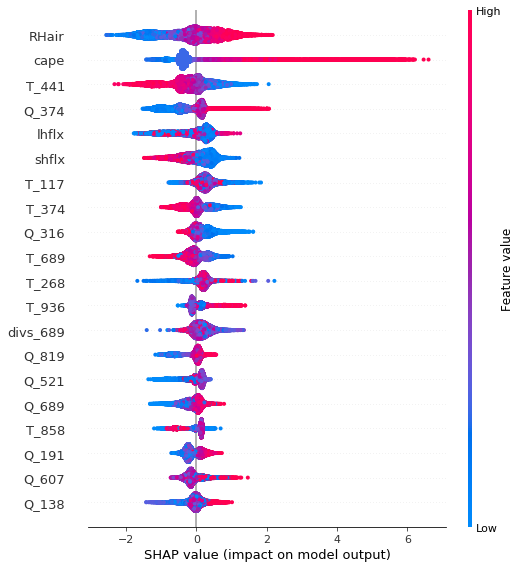

In [49]:
shap.summary_plot(shap_values, trig_x)

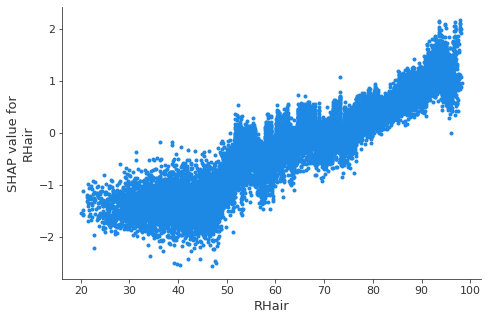

None


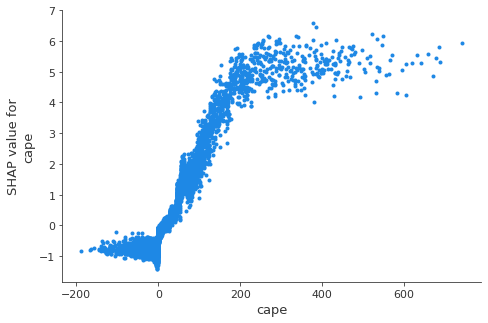

None


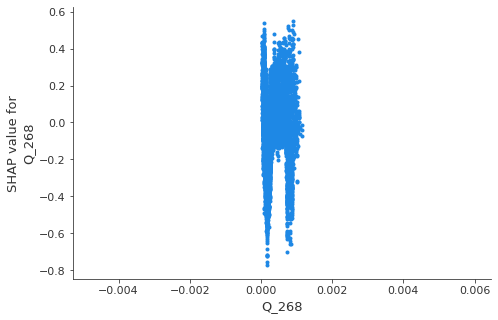

None


In [52]:
vars_name=['RHair','cape','Q_268']

for var in vars_name:
    shap.dependence_plot(var, shap_values, trig_x,interaction_index=None)
    

In [ ]:
shap_interaction_values = shap.TreeExplainer(bst).shap_interaction_values(trig_x)

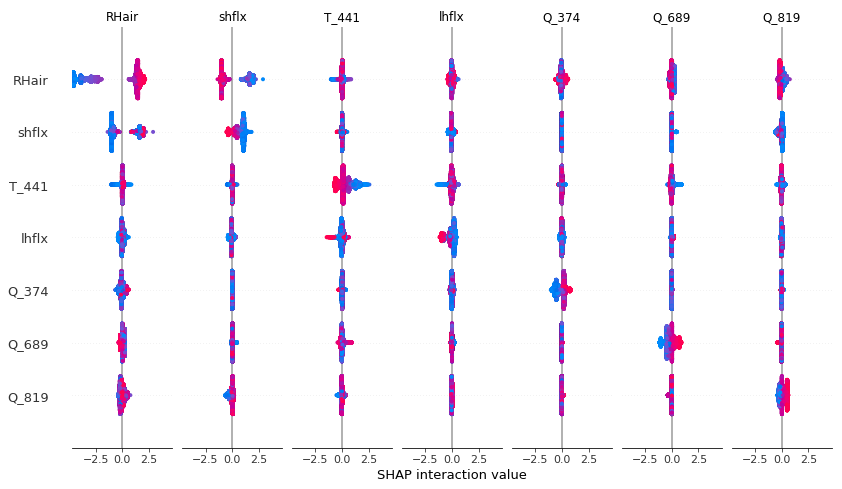

In [14]:
shap.summary_plot(shap_interaction_values, trig_x)

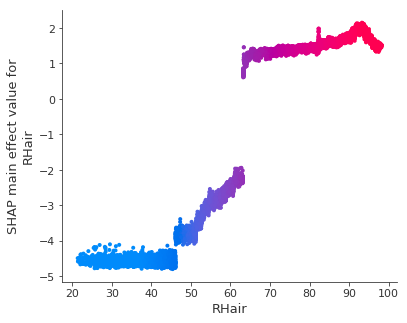

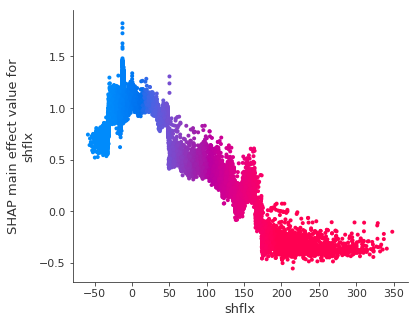

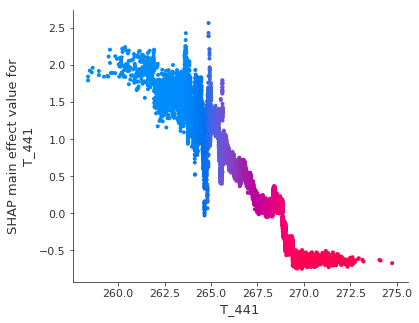

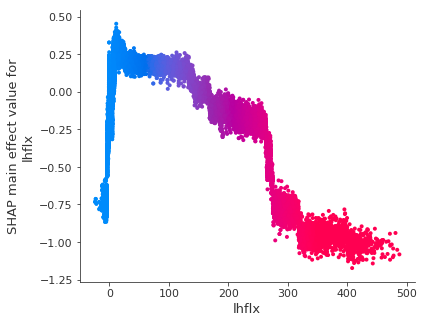

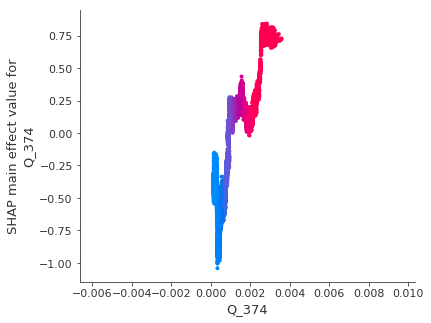

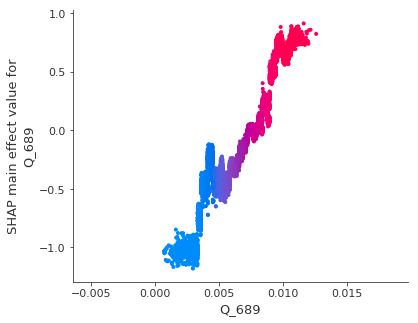

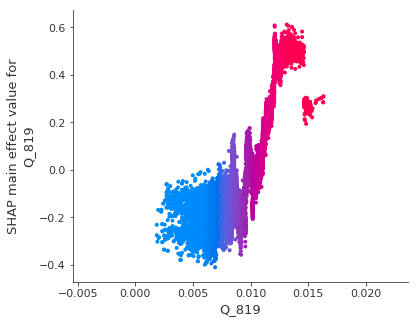

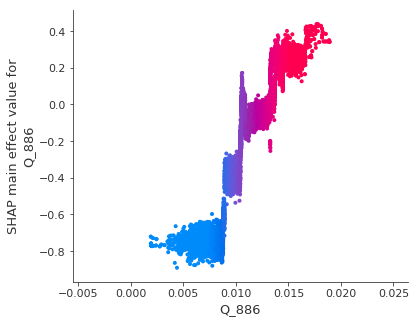

In [29]:
vars_name=['RHair','shflx','T_441','lhflx','Q_374','Q_689','Q_819','Q_886']
for var in vars_name:
    shap.dependence_plot(
        (var, var),
        shap_interaction_values, trig_x
        #display_features=X_display.iloc[:2000,:]
    )

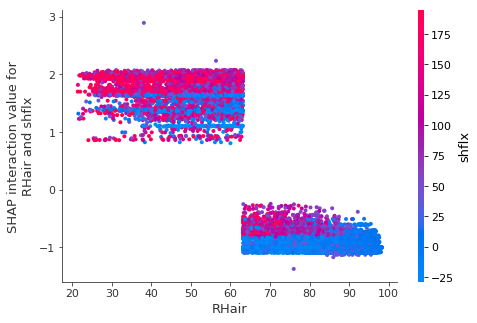

In [31]:
 shap.dependence_plot(('RHair', 'shflx'), shap_interaction_values, trig_x
        #display_features=X_display.iloc[:2000,:]
    )

In [12]:
from sklearn import tree
trig_x=dataset[['ddcape','RHair','Q_268']]
#trig_x=dataset[['cape']]
print(trig_x.shape)

trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
dt = tree.DecisionTreeClassifier(max_depth=3)

dt.fit(trig_x_train,trig_y_train)
trig_y_pred = dt.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
p  = precision_score(trig_y_test, trig_y_pred,average='macro')
r  = recall_score(trig_y_test, trig_y_pred,average='macro')
print(tp,fp,fn,tn)
print(f1,p,r)

(22800, 3)
194 51 228 4087
0.7743515560331748 0.8694989003712725 0.7236954226118348


In [6]:
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=3,scale_pos_weight=3.5)
xgb.fit(trig_x_train,trig_y_train)
trig_y_pred = xgb.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
p  = precision_score(trig_y_test, trig_y_pred,average='macro')
r  = recall_score(trig_y_test, trig_y_pred,average='macro')
print(xgb)
print(tp,fp,fn,tn)
print(f1,p,r)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=8, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.5, seed=None,
              silent=True, subsample=1, verbosity=1)
275 188 147 3950
0.7903944511335452 0.7790362858352342 0.8031130958243903


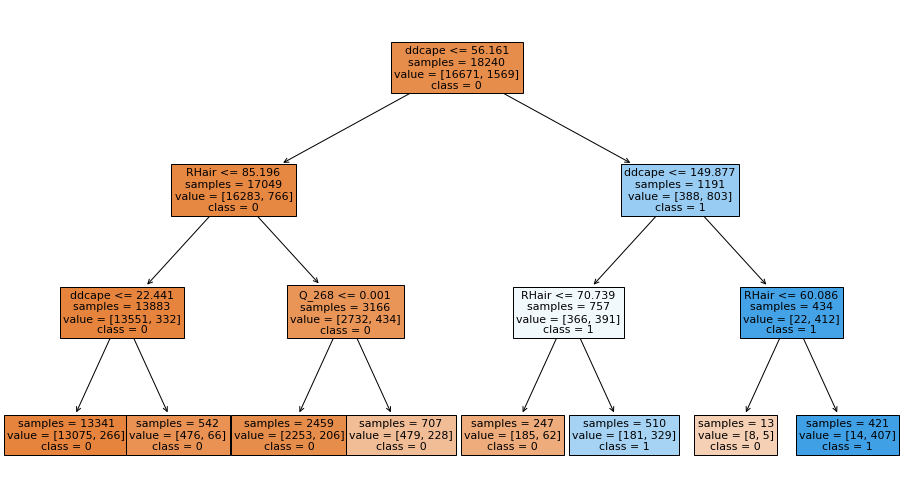

In [14]:
plt.figure(figsize=(16,9))
tree.plot_tree(dt.fit(trig_x_train,trig_y_train), proportion=False, impurity=False,filled=True, feature_names=trig_x.columns, label='all', fontsize=11, class_names=['0','1'])
plt.savefig("figs/SGP_dt.pdf")

In [40]:
TN = 2575
FN = 58
TP = 255
FP = 1

Precision_P = TP/(TP+FP)
Precision_N = TN/(TN+FN)
Recall_P = TP/(TP+FN)
Recall_N = TN/(TN+FP)
F1_P = 2 * Precision_P * Recall_P / (Precision_P + Recall_P)
F1_N = 2 * Precision_N * Recall_N / (Precision_N + Recall_N)

P  = (Precision_P + Precision_N) / 2
R  = (Recall_P + Recall_N) / 2
F1 = (F1_P+F1_N)/2
print(F1, P, R)

0.9424913821927102 0.9870328225883023 0.9071541434326196


1. 0.77 0.81 0.74  100%
2. 0.83 0.93 0.84  82.6%
3. 0.84 0.83 0.86  78.6%
4. 0.74 0.95 0.67  95.9%
5. 0.74 0.96 0.67  95.8%
6. 0.84 0.96 0.78  78.5%
7. 0.86 0.96 0.82  75.6%
8. 0.87 0.97 0.80  75.4%

